## Imports

In [1]:
import datetime
import functools
import os

import numpy as np
import pandas as pd

import scipy.stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['text.usetex'] = True

from lvml.experiment import *

## Load analysis files

In [2]:
from glob import glob
import pickle

n_runs = 10
dataset = 'movielens'

get_seed = lambda f: int(f.split('/')[-2].split('_')[-1].split('.')[0])
output_dir = os.path.expanduser(f'~/Documents/lvml/output/{dataset}_*/')
file_list = lambda basename: sorted([p for p in glob(f'{output_dir}/{basename}') if get_seed(p)>0], key=get_seed)[:n_runs]

In [3]:
read_csvs = lambda basename: pd.concat([
    pd.read_csv(f).assign(seed=get_seed(f))
    for f in file_list(basename)
])

read_pickles = lambda basename: {
    get_seed(f): pickle.load(open(f,'rb'))
    for f in file_list(basename)
}


results_df_combined = read_csvs('results_df.csv.zip')
optimizer_variations_results_df_combined = read_csvs('sensitivity_df.csv.zip')
safety_res_all = read_pickles('safety.pkl')
params_all = read_pickles('params.pkl')

## Prepare plots

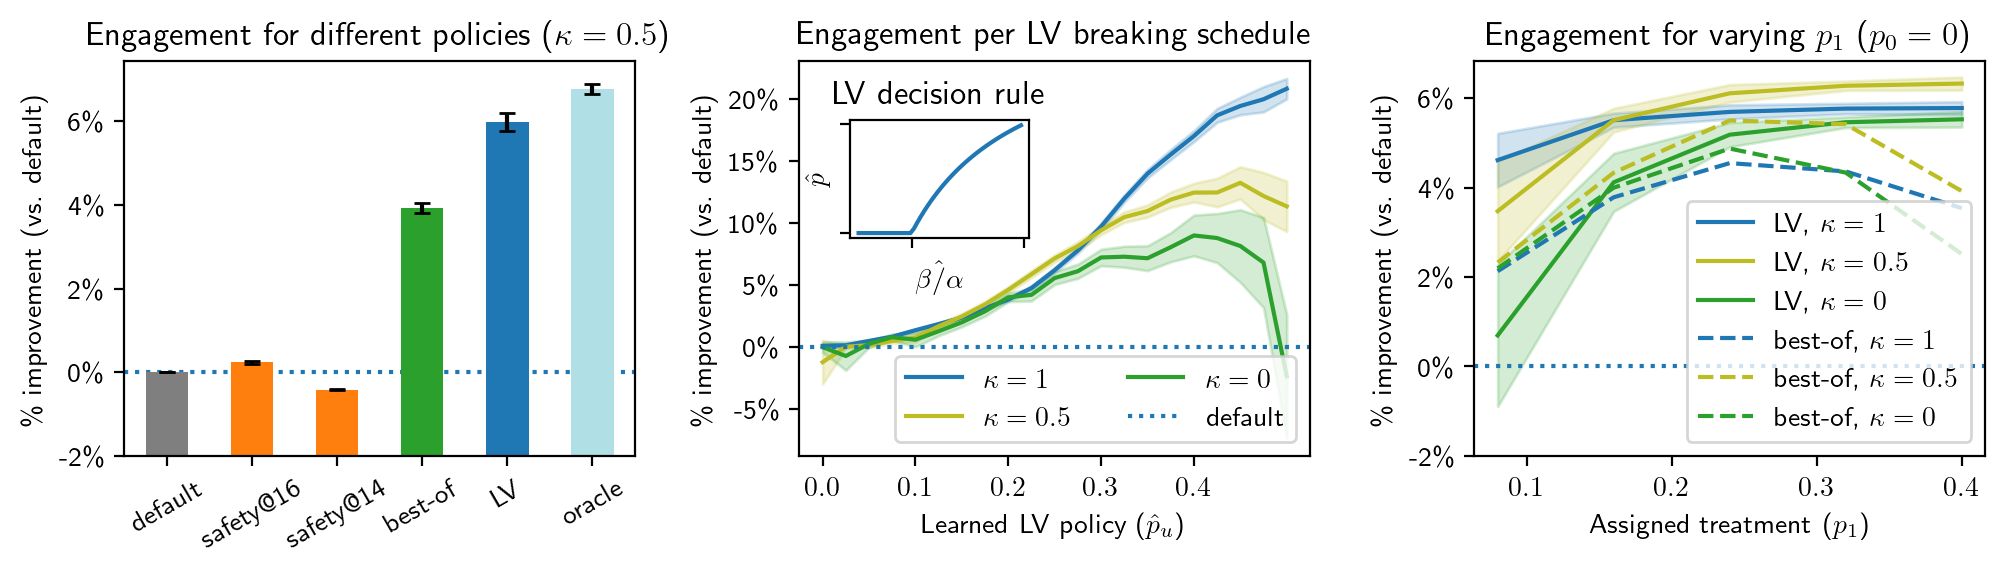

In [4]:
fig,axs=subplots_latex(
    1,3,
    row_width_type='textwidth',
    row_height_factor=0.18,
    tight_layout=dict(w_pad=2)
)

selected_simulator = 'discrete'
selected_kappa = 0.5
selected_predictor = 'linear_regression'
selected_safety_threshold_high = 16
selected_safety_threshold_low = 14

confidence_interval_alpha = 0.05

myopic_means = (
    results_df_combined
    .query('simulator=="discrete" and policy=="myopic" and predictor=="linear_regression" and kappa==@selected_kappa')
    .groupby('seed')
    ['rate']
    .mean()
)

kappa_colors={
    ('lv_engagement',1.0): 'tab:blue',
    ('lv_engagement',0.5): 'tab:olive',
    ('lv_engagement',0.0): 'tab:green',
    ('argmax',1.0): 'tab:red',
    ('argmax',0.5): 'tab:pink',
    ('argmax',0.0): 'tab:orange',
}

bar_plot_config={
    'default': ((selected_predictor,'myopic'), 'tab:gray', ''),
    f'safety@{selected_safety_threshold_high}': (('safety',selected_safety_threshold_high), 'tab:orange', ''),
    f'safety@{selected_safety_threshold_low}': (('safety',selected_safety_threshold_low), 'tab:orange', ''),
    'best-of': ((selected_predictor,'argmax'), 'tab:green', ''),
    'LV': ((selected_predictor,'lv_engagement'), 'tab:blue', ''),
    'oracle': (('oracle','lv_engagement'), 'powderblue', ''),
}

confidence_interval = lambda s: sm.stats.DescrStatsW(s).tconfint_mean(confidence_interval_alpha)

prediction_policy_comparison_df = (
    results_df_combined
    .query('simulator==@selected_simulator and kappa==@selected_kappa')
    .pivot('user_ind',['predictor','policy','seed'],'rate')
    .mean()
    .pipe(lambda s: s/s.loc[(selected_predictor,'myopic',slice(None))])
    .unstack()
    .apply(
        lambda row: pd.Series(
            {
                'mean': row.mean(),
                'yerr': confidence_interval(row)[1]-row.mean()
            }
        ),
        axis=1,
    )
)

safety_df = (
    pd.DataFrame(safety_res_all)
    .apply(lambda s: s.map(lambda arr: arr.mean()/myopic_means.loc[s.name]))
    .apply(
        lambda row: pd.Series(
            {
                'mean': row.mean(),
                'yerr': confidence_interval(row)[1]-row.mean()
            }
        ),
        axis=1,
    )
    .reset_index()
    .assign(policy='safety')
    .set_index(['policy','index'])
)

barplot_comparison_df=pd.concat([prediction_policy_comparison_df,safety_df])


def plot_barplot_comparison(ax):
    (
        barplot_comparison_df
        .loc[[t[0] for t in bar_plot_config.values()]]
        .pipe(lambda df: df['mean'].plot.bar(
            ax=ax,
            color=[t[1] for t in bar_plot_config.values()],
            hatch=[t[2] for t in bar_plot_config.values()],
            yerr=df['yerr'],
            capsize=3,
        ))
    )
    ax.axhline(1,linestyle=':',zorder=-1)
    ax.set(
        ylim=(0.98,1+(barplot_comparison_df['mean'].max()-1)*1.1),
        xticklabels=[n for n in bar_plot_config],
    )
    ax.xaxis.set_tick_params(rotation=30)
    ax.set(
        title=f'Engagement for different policies ($\kappa={selected_kappa}$)',
        xlabel=None,
    )
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round((x-1)*100)}\%'))
    return ax

plot_barplot_comparison(axs[0])

#
# Engagement vs. p
#

def plot_selected_policies(ax):
    for selected_kappa in [1.0,0.5,0.0]:
        (
            results_df_combined
            .query('simulator==@selected_simulator and kappa==@selected_kappa and predictor==@selected_predictor')
            .pipe(lambda df: pd.concat(
                [
                    (
                        df
                        .pivot(['seed','user_ind'],'policy','rate')
                        .apply(lambda row: row['lv_engagement']/(row['myopic']+1e-5)-1,axis=1)
                        .rename('gain')
                    ),
                    (
                        df
                        .query('policy=="lv_engagement"')
                        .set_index(['seed','user_ind'])
                        ['p_fb']
                    ),
                ],
                axis=1,
            ))
            .query('p_fb>1e-5')
            .assign(
                p_group=lambda df: quantize(df['p_fb'], res=0.025)
            )
            .groupby('p_group')
            ['gain']
            .agg([
                ('mean', 'mean'),
                ('ci', lambda s: confidence_interval(s)),
            ])
            .pipe(lambda df: [
                df['mean'].plot.line(
                    ax=ax,
                    label=f'$\kappa={selected_kappa:.1g}$',
                    color=kappa_colors[('lv_engagement',selected_kappa)],
                ),
                ax.fill_between(
                    df.index, 
                    df['ci'].map(lambda t: t[0]),
                    df['ci'].map(lambda t: t[1]),
                    alpha=0.2,
                    color=kappa_colors[('lv_engagement',selected_kappa)],
                )
            ])
        )

    ax.axhline(0, linestyle=':', label='default')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x*100)}\%'))
    ax.set(
        title='Engagement per LV breaking schedule',
        xlabel=r'Learned LV policy ($\hat{p}_u$)',
        xticks=np.arange(0,0.5,0.1)
    )

    ax.legend(
        loc='lower right',
        ncol=2,
    )


    axins = ax.inset_axes([0.1, 0.55, 0.35, 0.3])
    ba_theory_vec = np.linspace(1,4)[1:-1]
    ab_theory_vec = 1/ba_theory_vec
    axins.plot(ba_theory_vec, p_opt_f(ab_theory_vec))
    axins.set(
        title='LV decision rule',
        xlabel=r'$\hat{\beta/\alpha}$',
        ylabel=r'$\hat{p}$',
    )
    plt.setp(axins.get_xticklabels(), visible=False)
    plt.setp(axins.get_yticklabels(), visible=False)
    return ax, axins

plot_selected_policies(axs[1])

#
# Sensitivity
#

def plot_sensitivity(ax):
    for selected_policy, display_name in [('lv_engagement','LV'), ('argmax','best-of')]:
        for selected_kappa in [1.0,0.5,0.0]:
            color = kappa_colors[('lv_engagement',selected_kappa)]
            linestyle = '-' if selected_policy=='lv_engagement' else '--'
            (
                optimizer_variations_results_df_combined
                .query('predictor=="linear_regression" and mode=="two-treatment" and kappa==@selected_kappa')
                .drop(['predictor','mode','kappa'],axis=1)
                .groupby(['seed','p1','policy'])
                ['rate']
                .mean()
                .unstack()
                .apply(lambda row: row/row['myopic']-1, axis=1)
                .drop('myopic', axis=1)
                .groupby(level=1)
                .agg([
                    ('mean', 'mean'),
                    ('ci', lambda s: confidence_interval(s)),
                ])
                [selected_policy]
                .pipe(lambda df: [
                    df['mean'].plot.line(
                        ax=ax,
                        label=f'{display_name}, $\kappa={selected_kappa:.1g}$',
                        color=color,
                        linestyle=linestyle,
                    ),
                    ax.fill_between(
                        df.index, 
                        df['ci'].map(lambda t: t[0]),
                        df['ci'].map(lambda t: t[1]),
                        alpha=0.2,
                        color=color,
                    ) if selected_policy=='lv_engagement' else None
                ])
            )

    ax.axhline(0,linestyle=':')
    ax.legend(
        loc='lower right',
    )
    ax.set(
        title='Engagement for varying $p_1$ ($p_0=0$)',
        xlabel='Assigned treatment ($p_1$)',
        ylabel=r'\% improvement - engagement',
        ylim=(-0.02,None),
    )
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x*100)}\%'))
    return ax

plot_sensitivity(axs[2])

for i,ax in enumerate(axs):
    ax.set(
        ylabel=r'\% improvement (vs. default)',
    )
    
fig.download(f'{dataset}_experiment.pdf')

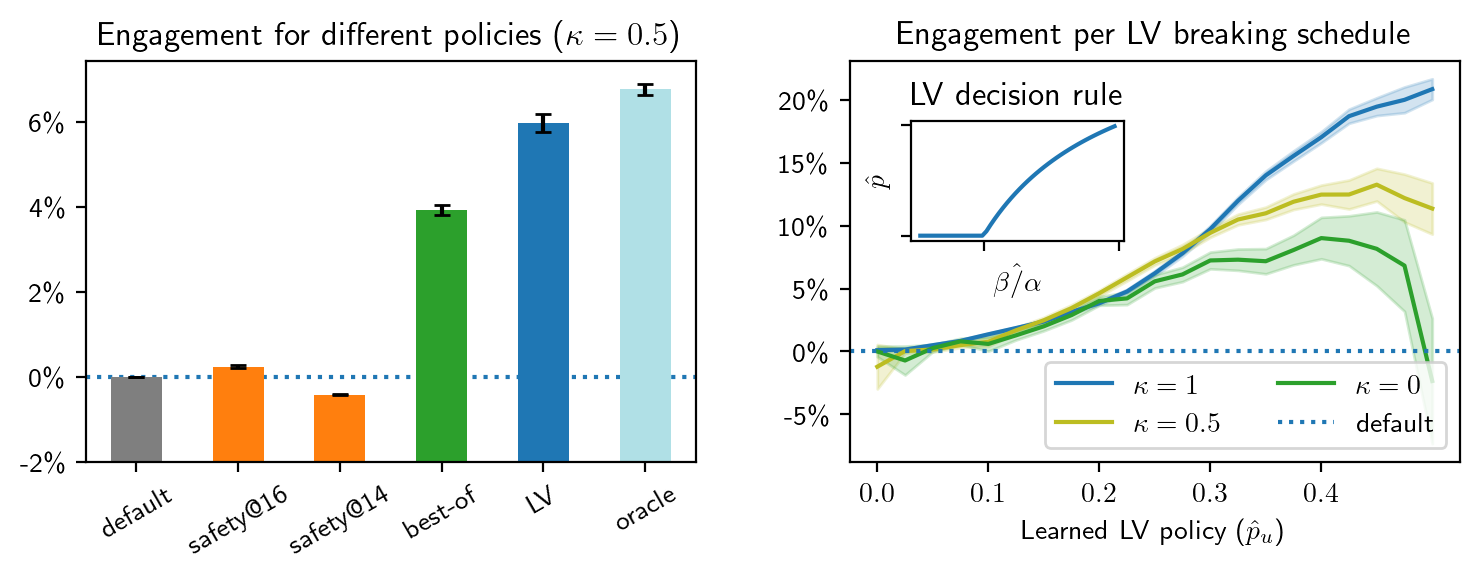

In [5]:
fig,axs=create_fig(1,2,figsize=(7.5,3))
plot_barplot_comparison(axs[0])
plot_selected_policies(axs[1])
fig.download(f'poster_{dataset}_experiment.pdf')

## Combine params

In [6]:
base_seed = min(params_all)
keys = sorted(params_all[base_seed].keys())
combined_params = {}
for k in keys:
    if k in ['random_state']:
        continue
    if all(np.allclose(d[k],params_all[base_seed][k]) for d in params_all.values()):
        combined_params[k] = params_all[base_seed][k] 
    elif not hasattr(params_all[base_seed][k], '__iter__'):
        print(f'Averaging {k}')
        vals = np.array([d[k] for d in params_all.values()])
        print(f'mean={vals.mean():.3g}, std={vals.std():.2g}')
        combined_params[k] = vals.mean() if not isinstance(params_all[base_seed][k], int) else round(vals.mean())
    else:
        print(f'Skipping {k}')
        print([d[k] for d in params_all.values()])


Averaging cf_rmse
mean=0.917, std=0.00084
Averaging total_simulation_time_minutes
mean=33, std=16


In [7]:
performance_comparison_pct_df = (
    barplot_comparison_df
    .loc[([selected_predictor,'oracle','safety'], slice(None)),'mean']
    .pipe(lambda s: s.loc[(selected_predictor,'lv_engagement')]-s)
    .apply(lambda s: s*100)
)

confidence_level_df = (
    barplot_comparison_df
    .loc[([selected_predictor,'oracle','safety'], slice(None)),'yerr']
    .apply(lambda s: s*100)
)

combined_params['overall_improvement_over_myopic'] = performance_comparison_pct_df.loc[(selected_predictor, 'myopic')]
combined_params['overall_improvement_over_argmax'] = performance_comparison_pct_df.loc[(selected_predictor, 'argmax')]
combined_params['overall_improvement_over_oracle'] = performance_comparison_pct_df.loc[('oracle', 'lv_engagement')]
combined_params['overall_improvement_over_safety'] = performance_comparison_pct_df.loc[('safety', selected_safety_threshold_high)]

combined_params['overall_improvement_over_myopic_confidence'] = confidence_level_df.loc[(selected_predictor, 'myopic')]
combined_params['overall_improvement_over_argmax_confidence'] = confidence_level_df.loc[(selected_predictor, 'argmax')]
combined_params['overall_improvement_over_oracle_confidence'] = confidence_level_df.loc[('oracle', 'lv_engagement')]
combined_params['overall_improvement_over_safety_confidence'] = confidence_level_df.loc[('safety', selected_safety_threshold_high)]

combined_params['num_repetitions'] = len(params_all)
combined_params['confidence_interval_alpha'] = confidence_interval_alpha
combined_params['confidence_level_pct'] = round(100*(1-confidence_interval_alpha))

In [8]:
pickle.dump(combined_params, open(f'./output/{dataset}_combined_params.pkl','wb'))